### Load Data

In [1]:
import pandas as pd
import re
from itertools import chain
import itertools

In [2]:
#from google.colab import drive
#drive.mount("/content/gdrive/")
#df1 = pd.read_stata("/content/gdrive/My Drive/mpaz_master_NATIVE.dta")
df1 = pd.read_stata("mpaz_master_NATIVE.dta")
df1.columns

Index(['master_id', 'plan', 'match_rate', 'default_contribution', 'd1', 'd0',
       'low', 'med', 'high', 'd1_low',
       ...
       'e1_happy_overall_rescaled', 'e1_life_satisfied', 'e1_nights_eating',
       'e1_fin_satisfaction', 'e1_confident_finance_current',
       'e1_conf_fin_current_rescaled', 'e1_confident_finance_future',
       'e1_conf_fin_future_rescaled', 'e1_will_retire',
       'e1_not_too_many_expenses'],
      dtype='object', length=425)

#### General cleaning

In [3]:
df= df1.copy()
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0]) # normalize categorial data
df.fillna(0,inplace=True)
df['consult_scenarios_asked'] = df['consult_scenarios_asked'].apply(lambda x: 1 if x!= ""else 0)

### Data exploration

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing 
import numpy as np
from itertools import combinations

##### Stick to default

In [6]:
change_cbn = df.loc[:,'changed_cbn_never':'changed_smsday']
begin_default = df.loc[:,'changed_cbn_jan']

In [7]:
end_default = df['changed_cbn_never']

##### Reasons of sticking to default or switch

In [8]:
switch = df1.loc[:,'switch_reason1':'switch_reason16']
switch.sum()

switch_reason1      49.0
switch_reason2      52.0
switch_reason3      35.0
switch_reason4       4.0
switch_reason5      24.0
switch_reason10    107.0
switch_reason11    189.0
switch_reason12     10.0
switch_reason15      8.0
switch_reason16      5.0
dtype: float64

In [5]:
plt.bar(np.arange(len(switch.columns))+0.3,switch.sum(axis=0).to_numpy(),alpha = 0.4)
plt.xlabel('switch reasons',size=12)
plt.ylabel('number of observations',size=12)

NameError: name 'switch' is not defined

**Reasons of swtiching default option**

switch_reason1:Decreased - Incentives Too Low;

switch_reason2:Decreased - Salary Too Low;

switch_reason3:Decreased - Expenses Too High;

switch_reason4:Decreased - Better Alternatives;

switch_reason5:Decreased - Un-Islamic Product;

switch_reason10:Increased - Responding to Incentives;

switch_reason11:Increased - Savings Important;

switch_reason12:Increased - Support Roshan Products;

switch_reason15:Increased - Demand for Commitment;

switch_reason16:Increased - Thought Deposits Automatic;
 

In [6]:
at_default_reason = df1.loc[pd.notna(df1['p1_atdefault_reason1'])].loc[:,'p1_atdefault_reason1':'p1_atdefault_reason_other']
at_default_reason = at_default_reason.apply(lambda x: pd.factorize(x)[0])
at_default_reason['p1_atdefault_reason_other'] = at_default_reason['p1_atdefault_reason_other'].apply(lambda x: 0 if x==0 or x ==-1 else 1)
at_default_reason.sum()

p1_atdefault_reason1          57
p1_atdefault_reason2           9
p1_atdefault_reason3           5
p1_atdefault_reason4          13
p1_atdefault_reason5          10
p1_atdefault_reason6         108
p1_atdefault_reason7           4
p1_atdefault_reason8           9
p1_atdefault_reason9           5
p1_atdefault_reason10         13
p1_atdefault_reason11          0
p1_atdefault_reason12          0
p1_atdefault_reason13          5
p1_atdefault_reason14          6
p1_atdefault_reason_other    104
dtype: int64

Text(0, 0.5, 'number of observations')

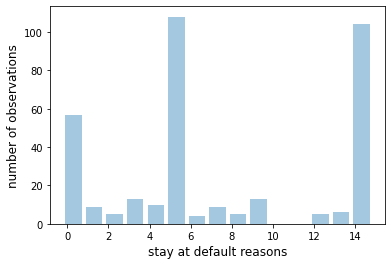

In [7]:
#plt.figure(figsize=(12,8))
plt.bar(np.arange(len(at_default_reason.columns))+0.3,at_default_reason.sum(axis=0).to_numpy(),alpha = 0.4)
plt.xlabel('stay at default reasons',size=12)
plt.ylabel('number of observations',size = 12)

**Reasons of stay at default**

p1_atdefault_reason1 : I am happy with my default contribution rate;

p1_atdefault_reason2: I do not want to save more money;

p1_atdefault_reason3 : I do not want to save less money;

p1_atdefault_reason4: I do not want to save any money since my salary is too low;

p1_atdefault_reason5: I do not trust saving my money in M-Pasandaz account;

p1_atdefault_reason6: My salary is low and I can?t afford saving;

p1_atdefault_reason7: I already have other saving accounts for saving my money;

p1_atdefault_reason8: I did want to change my plan but did not have time to call HR;

p1_atdefault_reason9: I want to change my plan but do not know how;

p1_atdefault_reason10:I intend to change my plan but have not yet;
p1_atdefault_reason11 : My friends? plans were better than mine;
p1_atdefault_reason12:My friends? plans worse than mine;
p1_atdefault_reason13: I had not thought about it at all;

p1_atdefault_reason14:I wanted to change my contribution but I forgot to call;


In [8]:
df1['p1_atdefault_reason_other'].unique()

['I am not intrested in M-Pasandaz', NaN, 'I didn?t understand the system / I don?t have..., 'My cart was white which not have any profit', 'Don?t want to particepate changed my contribu..., ..., 'I have to pay my other loan', 'I don?t have plan to do saving', 'No possible to changed my contributioin in si..., 'I am a contractor', 'I want to check that M-Passandaz is working o...]
Length: 16
Categories (15, object): ['Don?t want to particepate changed my contribu... < 'Don?t want to particepate in M-Pasandaz' < 'Don?t want to particepate in M-Pasandaz it is... < 'Not giving good profit' ... 'I didn?t understand the system / I don?t have... < 'I don?t have plan to do saving' < 'I want to check that M-Passandaz is working o... < 'I am a contractor']

In [9]:
switch = df.loc[:,'switch_reason1':'switch_reason16']
at_default_reason = df.loc[:,'p1_atdefault_reason1':'p1_atdefault_reason_other']
reasons= pd.concat([switch,at_default_reason],axis=1)
reasons = reasons.replace(-1,0)
reasons['p1_atdefault_reason_other'] = reasons['p1_atdefault_reason_other'].apply(lambda x: 1 if x!=0 else x)
reasons['p1_atdefault_reason_other'].unique()
reasons['sum'] = reasons.sum(axis=1)

In [10]:
(reasons['sum'] >0).sum()

645

##### Beginning investigation
Includes social identification,financial background, present_bias,risk perference

In [11]:
columns = list(df.loc[:,'education_level':'asset_livestock'].columns)
columns.extend(['tenure','salary_jan'])
begin_info = df.loc[:,columns]
begin_info.columns

Index(['education_level', 'missed_meals', 'withdraw_entire_salary',
       'total_savings', 'uses_bank', 'male', 'bank_savings', 'cash_savings',
       'loans_given', 'mpaisa_savings', 'mpaz_savings', 'savings_other_form',
       'total_savings_calc', 'food_expenditure_week',
       'general_expenditures_month', 'married', 'interest', 'fail_pay', 'age',
       'intelligence', 'delta_bl', 'beta_bl', 'time_inconsistent_baseline',
       'fix_phone_self', 'income_transfers', 'total_income', 'risk_general',
       'asset_bed', 'asset_stove', 'asset_washing', 'asset_ac', 'asset_heater',
       'asset_fridge', 'asset_room', 'asset_tv', 'asset_dvd', 'asset_phone',
       'asset_computer', 'asset_bicycle', 'asset_motorcycle', 'asset_car',
       'asset_sewing', 'asset_livestock', 'tenure', 'salary_jan'],
      dtype='object')

##### Intervention : financial consultance

In [12]:
consult= df.loc[:,'consultyn':'changed_consult']
consult['consult_scenarios_asked'] = consult['consult_scenarios_asked'].apply(lambda x: 1 if x!= ""else 0)
consult.columns

Index(['consultyn', 'consult_oldcbn', 'consult_newcbn', 'consult_talk_now',
       'consult_wants_overview', 'consult_aware_rate',
       'consult_wants_scenarios', 'consult_questions1', 'consult_repeatinfo',
       'consult_scenarios_asked', 'consult_questions2', 'consult_notreached',
       'changed_consult'],
      dtype='object')

##### Experiment related

In [13]:
experiment_con = df.loc[:,['default_contribution','participates','low','med','high']]
balance = df.loc[:,'mpaz_balance_jan':'mpaz_balance_jun'].columns
flow = df.loc[:,'mpaisa_flow_jun':'mpaisa_flow_baseline'].columns
panels = df.loc[:,'p1_total_income':'p4_total_savings_adj']
contribution_rate = df.loc[:,'cbn':'cbn_jun'].columns
experiment = list(chain(*zip(experiment_con,balance, flow, contribution_rate)))
experiment = df.loc[:,experiment]

##### End investigation

In [14]:
pd.notna(df1['e1_injured']).sum()

816

In [15]:
end_info = df.loc[:,'e1_save_important_survey':'delta_el']
end_info = end_info.drop('e1_interview_date',axis=1)
end_info = end_info.drop('e1_desire_to_change',axis=1)
end_info.columns

Index(['e1_save_important_survey', 'e1_random_assignment_beliefs',
       'e1_missed_meals', 'e1_cereal', 'e1_meat', 'e1_vegetables', 'e1_dairy',
       'e1_condiments', 'e1_meals_away', 'e1_fuel',
       ...
       'e1_violence_prime', 'money_mpaz_plan', 'financialproduct_mpaz',
       'money_mpaz_spent', 'e1_switch_a', 'e1_switch_left_a', 'e1_switch_b',
       'e1_switch_left_b', 'beta_el', 'delta_el'],
      dtype='object', length=124)

##### Change of savings desire

In [16]:
change_desire = df['e1_changed_desire']

### Models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from scikeras.wrappers import KerasClassifier

import random
random.seed(10)
import tensorflow as tf
tf.random.set_seed(19)
from tensorflow import keras
from tensorflow.keras import layers
import shap


In [18]:
def pca(input_):
    pca_out= PCA().fit(input_)
    plt.plot(np.cumsum(pca_out.explained_variance_ratio_))
    plt.plot(np.repeat(0.95,len(pca_out.explained_variance_ratio_)))
    plt.xlabel('components',size=12)
    plt.ylabel('explained_variance_ratio',size=12)
    return plt.show()

def kpca(input_,length):
    transformer = KernelPCA(n_components=None, kernel='poly')
    transformer.fit(input_)
    plt.plot(np.cumsum(transformer.eigenvalues_/np.sum(transformer.eigenvalues_))[:length])
    plt.plot(np.repeat(0.95,length))
  #plt.ylim(bottom=0)
    plt.xlabel('kernel_components',size=12)
    plt.ylabel('explained_variance_ratio',size=12)
    return plt.show()

def plot_all(input_,length):
    fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
    pca_out= PCA().fit(input_)
    ax1.plot(np.cumsum(pca_out.explained_variance_ratio_))
    ax1.plot(np.repeat(0.95,len(pca_out.explained_variance_ratio_)))
    ax1.set_xlabel('components',size=12)
    ax1.set_ylabel('explained_variance_ratio',size=12)
    transformer = KernelPCA(n_components=None, kernel='poly')
    transformer.fit(input_)
    ax2.plot(np.cumsum(transformer.eigenvalues_/np.sum(transformer.eigenvalues_))[:length])
    plt.plot(np.repeat(0.95,length))
    plt.xlabel('kernel_components',size=12)
    plt.ylabel('explained_variance_ratio',size=12) 
    return plt.show()

In [19]:
logit =  LogisticRegression(random_state=42)
trees = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(random_state=42)
svm1  = svm.SVC(random_state=42)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=5, cv=3)

In [20]:
tree_pm = {'criterion':('gini', 'entropy'),'splitter':['best', 'random'],
          'max_depth':np.arange(5,20,1),}
forest_pm = {'n_estimators':np.arange(80,120,1),'criterion':('gini', 'entropy'),
           'max_depth':np.arange(5,15,1)} 
svm_pm = {'kernel':['linear','poly', 'rbf', 'sigmoid', 'precomputed'],
          'degree':np.arange(3,6,1),'gamma':['scale','auto'] }
            
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [5, 10, 15, 20, 25, 30]
            
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

In [21]:
def LR(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    return accuracy,clf

def DT(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    grid = GridSearchCV(estimator=trees, param_grid=tree_pm, n_jobs=5, cv=3)
    grid_result = grid.fit(X_train,y_train)
    param = grid_result.best_params_
    clf = DecisionTreeClassifier(criterion=param['criterion'],
                                 max_depth = param['max_depth'], 
                                 splitter= param['splitter'], random_state=42)
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    return param,accuracy,clf

def RF(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    grid = GridSearchCV(estimator=forest, param_grid=forest_pm, n_jobs=5, cv=3)
    grid_result = grid.fit(X_train,y_train)
    param = grid_result.best_params_
    clf = RandomForestClassifier(criterion=param['criterion'],
                                 max_depth = param['max_depth'],
                                 n_estimators=param['n_estimators'],random_state=42)
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    return param, accuracy,clf

def NN_bi(X,y):    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    model = create_binary_model(X_train)
    model.fit(X_train,y_train,validation_split=0.1,batch_size= 50,epochs=5)
    accuracy = model.evaluate(X_test,y_test)[1]
    return accuracy,model

def NN_mi(X,y):    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    model = create_class_model(X_train,y_train)
    model.fit(X_train,y_train,validation_split=0.1,batch_size= 50,epochs=5)
    accuracy = model.evaluate(X_test,y_test)[1]
    return accuracy,model

In [23]:
def create_binary_model(input_):   
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    inputs = keras.Input(shape=(input_.shape[1],))
    x = tf.keras.layers.Dense(5, activation=tf.nn.tanh)(inputs)
    outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'binary_crossentropy', metrics=['accuracy'],optimizer='Adamax')
    return model

def create_class_model(input_,output_):
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    inputs = keras.Input(shape=(input_.shape[1],))
    x = tf.keras.layers.Dense(15, activation=tf.nn.tanh)(inputs) 
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(output_.shape[1], activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')
    return model

### Results

#### Predicting stick to default(begining stage)

In [25]:
input_ = pd.concat([begin_info,experiment_con],axis=1)
input_.describe()
input_std = preprocessing.StandardScaler().fit_transform(input_)
input_.shape

(949, 50)

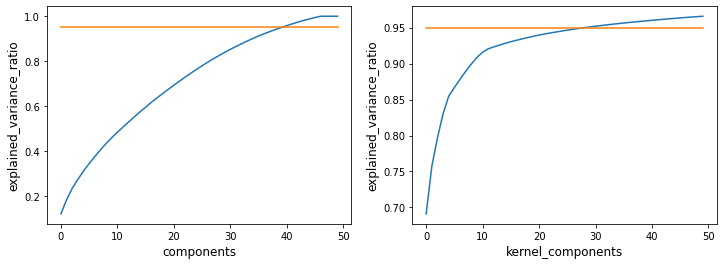

In [26]:
plot_all(input_std,50)

In [27]:
X = KernelPCA(n_components=30, kernel='poly').fit_transform(input_std)
X_train,X_test,y_train,y_test = train_test_split(X,df['changed_cbn_jan'],test_size=0.3, random_state=42)
X_train.shape

(664, 30)

##### Models

###### Logistic Regression

In [28]:
LR(input_,df['changed_cbn_jan'])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


(0.6350877192982456, LogisticRegression(random_state=42))

In [29]:
LR(input_std,df['changed_cbn_jan'])

(0.6456140350877193, LogisticRegression(random_state=42))

In [30]:
LR(X,df['changed_cbn_jan'])

(0.624561403508772, LogisticRegression(random_state=42))

###### Decision Tree

In [31]:
DT(input_,df['changed_cbn_jan'])

({'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'},
 0.8,
 DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42))

In [32]:
DT(input_std,df['changed_cbn_jan'])

({'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'},
 0.8,
 DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42))

In [33]:
DT(X,df['changed_cbn_jan'])

({'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'},
 0.6385964912280702,
 DecisionTreeClassifier(max_depth=5, random_state=42, splitter='random'))

###### Random Forest

In [34]:
RF(input_,df['changed_cbn_jan'])

({'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 119},
 0.7087719298245614,
 RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=119,
                        random_state=42))

In [35]:
RF(input_std,df['changed_cbn_jan'])

({'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 115},
 0.7298245614035088,
 RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=115,
                        random_state=42))

In [36]:
RF(X,df['changed_cbn_jan'])

({'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 96},
 0.6526315789473685,
 RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=96,
                        random_state=42))

###### Neural Network

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def create_model(optimizer='Adam'):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(3, input_shape=(50,), activation='softmax'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', metrics=['accuracy'],optimizer=optimizer)
    return model
tf.random.set_seed(7)
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [3,5,7, 10,12, 15,17,20]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
model = KerasClassifier(model=create_model,
                       loss="binary_crossentropy",metrics='accuracy', epochs=5, batch_size=50, verbose=0)
#param_grid = dict(model__neurons=neurons)
#param_grid = dict(model__activation=activation)
param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy', n_jobs=5, cv=3)

In [39]:
# tuning neruons
X_train,X_test,y_train,y_test = train_test_split(input_,df['changed_cbn_jan'],test_size=0.3, random_state=42)
grid_result = grid.fit(X_train,y_train)
print(grid_result.best_params_,grid_result.best_score_)

{'model__optimizer': 'SGD'} 0.6626513391219273


In [40]:
# tuning activation
grid_result = grid.fit(X_train,y_train)
print(grid_result.best_params_,grid_result.best_score_)

{'model__optimizer': 'SGD'} 0.6626513391219273


In [41]:
# tuning optimizer
grid_result = grid.fit(X_train,y_train)
print(grid_result.best_params_,grid_result.best_score_)

{'model__optimizer': 'SGD'} 0.6626513391219273


In [42]:
def create_binary_model(input_):   
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    inputs = keras.Input(shape=(input_.shape[1],))
    x = tf.keras.layers.Dense(7, activation=tf.nn.softmax)(inputs)
    outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'binary_crossentropy', metrics=['accuracy'],optimizer='Adam')
    return model

In [43]:
NN_bi(X,df['changed_cbn_jan'])

Epoch 1/5
12/12 [==============================] - 1s 19ms/step - loss: 0.6756 - accuracy: 0.6482 - val_loss: 0.6978 - val_accuracy: 0.4925
Epoch 2/5
12/12 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.6566 - val_loss: 0.6971 - val_accuracy: 0.5075
Epoch 3/5
12/12 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6583 - val_loss: 0.6967 - val_accuracy: 0.5075
Epoch 4/5
12/12 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.6683 - val_loss: 0.6963 - val_accuracy: 0.5224
Epoch 5/5
9/9 [==============================] - 0s 1ms/step - loss: 0.6616 - accuracy: 0.6456


(0.6456140279769897, <keras.engine.functional.Functional at 0x276378dd070>)

In [44]:
NN_bi(input_std,df['changed_cbn_jan'])

Epoch 1/5
12/12 [==============================] - 1s 13ms/step - loss: 0.6750 - accuracy: 0.6064 - val_loss: 0.6831 - val_accuracy: 0.5821
Epoch 2/5
12/12 [==============================] - 0s 4ms/step - loss: 0.6689 - accuracy: 0.6265 - val_loss: 0.6817 - val_accuracy: 0.5672
Epoch 3/5
12/12 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6365 - val_loss: 0.6804 - val_accuracy: 0.5522
Epoch 4/5
12/12 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6566 - val_loss: 0.6794 - val_accuracy: 0.5522
Epoch 5/5
9/9 [==============================] - 0s 1ms/step - loss: 0.6565 - accuracy: 0.6421


(0.6421052813529968, <keras.engine.functional.Functional at 0x276379eb190>)

##### Explanation

In [45]:
X_train,X_test,y_train,y_test = train_test_split(input_,df['changed_cbn_jan'],test_size=0.3, random_state=42)
model = DT(input_,df['changed_cbn_jan'])[2]
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
            columns=shap_test.feature_names, 
            index=X_test.index)
shap_df

,education_level,missed_meals,withdraw_entire_salary,total_savings,uses_bank,male,bank_savings,cash_savings,loans_given,mpaisa_savings,...,asset_car,asset_sewing,asset_livestock,tenure,salary_jan,default_contribution,participates,low,med,high
199,0.0,0.0,0.0,0.0,0.004434,0.0,0.0,-0.001353,0.0,0.0,...,0.0,-0.000679,0.0,0.0,0.012516,-0.172550,-0.224496,-0.144306,0.0,-0.001217
660,0.0,0.0,0.0,0.0,-0.018990,0.0,0.0,-0.003547,0.0,0.0,...,0.0,-0.003357,0.0,0.0,0.008589,-0.215667,0.006147,-0.103648,0.0,-0.003192
692,0.0,0.0,0.0,0.0,0.009059,0.0,0.0,-0.001131,0.0,0.0,...,0.0,-0.000540,0.0,0.0,-0.134171,-0.046805,-0.018890,0.047941,0.0,-0.001017
737,0.0,0.0,0.0,0.0,0.011207,0.0,0.0,-0.003547,0.0,0.0,...,0.0,-0.003357,0.0,0.0,-0.015980,-0.240606,-0.073008,0.010914,0.0,-0.003192
774,0.0,0.0,0.0,0.0,0.004434,0.0,0.0,0.010816,0.0,0.0,...,0.0,-0.000627,0.0,0.0,-0.027216,0.087671,0.253672,0.030682,0.0,0.015383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,0.0,0.0,0.0,0.0,0.011207,0.0,0.0,-0.025251,0.0,0.0,...,0.0,0.021544,0.0,0.0,0.016247,-0.267389,0.005915,0.011177,0.0,-0.021521
678,0.0,0.0,0.0,0.0,0.009059,0.0,0.0,-0.002763,0.0,0.0,...,0.0,-0.000377,0.0,0.0,-0.033926,-0.069985,-0.034262,0.038448,0.0,0.003384
616,0.0,0.0,0.0,0.0,-0.025538,0.0,0.0,-0.001688,0.0,0.0,...,0.0,-0.000968,0.0,0.0,0.013809,0.290954,0.309394,-0.107862,0.0,-0.001519
404,0.0,0.0,0.0,0.0,-0.018990,0.0,0.0,0.005675,0.0,0.0,...,0.0,-0.003357,0.0,0.0,0.001919,-0.213598,0.007215,-0.100298,0.0,-0.016233


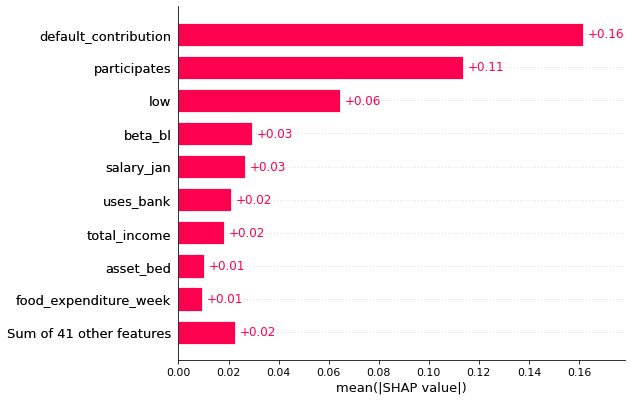

In [46]:
shap.plots.bar(shap_test[:,:,1])

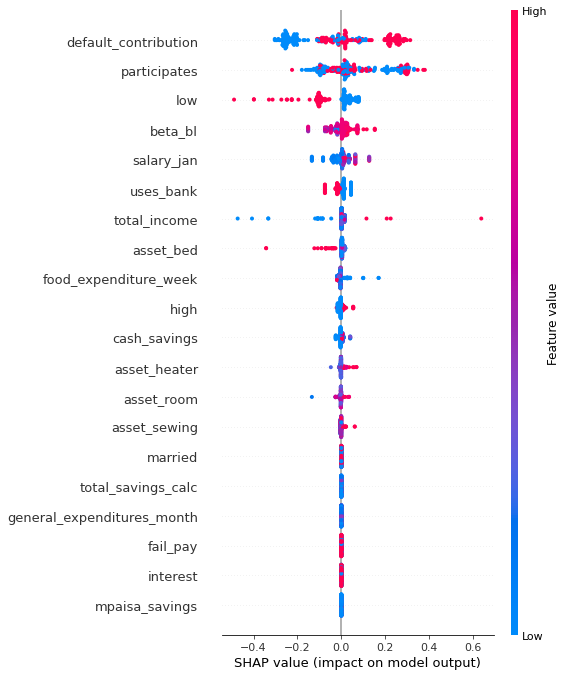

In [47]:
fig=plt.gcf()
shap.summary_plot(shap_test[:,:,1],show=False)
plt.savefig('shap_distribution.png')

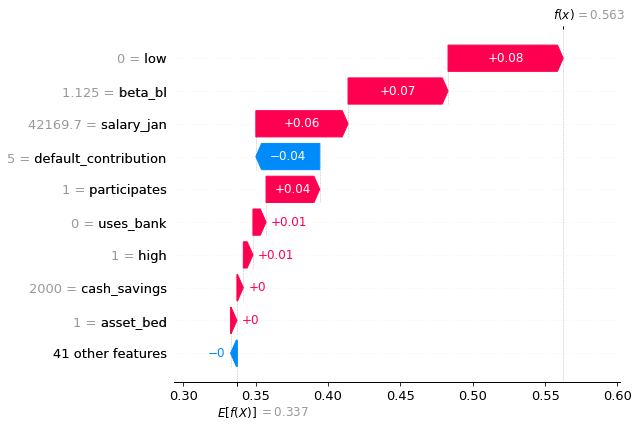

In [48]:
shap.plots.waterfall(shap_test[:,:,1][10])

#### predicting staying at default/switching reason

In [50]:
input_ = pd.concat([begin_info,experiment],axis=1)
input_ = pd.concat([input_,consult],axis=1)
input_ = pd.concat([input_,reasons],axis=1)
input_ = input_.loc[input_['sum']>0]

In [51]:
output = ['p1_atdefault_reason1','p1_atdefault_reason6','switch_reason1',
          'switch_reason2','switch_reason3','switch_reason10','switch_reason11']
y = input_.loc[:,output]
input_ = input_.iloc[:,:78]
input_.shape

(645, 78)

In [52]:
input_std = preprocessing.StandardScaler().fit_transform(input_)

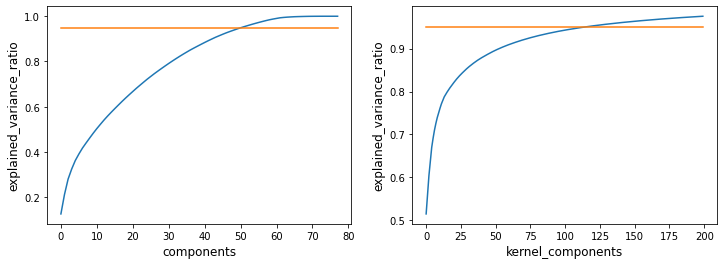

In [53]:
plot_all(input_std,200)

In [54]:
X = PCA(n_components=50).fit_transform(input_std)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
X_train.shape

(451, 50)

##### Models

###### Decision Tree 

In [55]:
print(input_.shape,y.shape)

(645, 78) (645, 7)


In [56]:
DTo = DT(input_,y) #  predict with the original dataset

In [57]:
DTo

({'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'},
 0.3711340206185567,
 DecisionTreeClassifier(max_depth=5, random_state=42))

In [58]:
DTt = DT(X,y)  # predict with pca transoformed dataset

In [59]:
DTt

({'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'},
 0.25773195876288657,
 DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42,
                        splitter='random'))

###### Random Forest 

In [62]:
RFo = RF(input_,y)

In [63]:
RFo

({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 112},
 0.3917525773195876,
 RandomForestClassifier(max_depth=5, n_estimators=112, random_state=42))

In [63]:
RFt = RF(X,y)

In [64]:
RFt

({'criterion': 'gini', 'max_depth': 7, 'n_estimators': 81},
 0.30412371134020616,
 RandomForestClassifier(max_depth=7, n_estimators=81, random_state=42))

###### Neural Networks

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def create_model(activation='softmax'):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(5, input_shape=(78,), activation=activation))
    model.add(Dense(7, kernel_initializer='uniform', activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer='SGD')
    return model
tf.random.set_seed(7)
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [3,5,7, 10,12, 15,17,20]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
model = KerasClassifier(model=create_model,
                       loss="categorical_crossentropy",metrics='accuracy',epochs=5, batch_size=50, verbose=0)

#param_grid = dict(model__neurons=neurons)
param_grid = dict(model__activation=activation)
#param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy', n_jobs=5, cv=3)

In [65]:
X_train,X_test,y_train,y_test = train_test_split(input_std,y,test_size=0.3, random_state=42)# tuning neruons  with original dataset
grid_result = grid.fit(X_train,y_train) 
print(grid_result.best_params_, grid_result.best_score_)

{'model__activation': 'softmax'} 0.243841059602649


In [66]:
grid_result = grid.fit(X_train,y_train) # tuning activation 
print(grid_result.best_params_, grid_result.best_score_)

{'model__activation': 'softmax'} 0.243841059602649


In [67]:
grid_result = grid.fit(X_train,y_train) # tuning opimizer 
print(grid_result.best_params_, grid_result.best_score_)

{'model__activation': 'softmax'} 0.243841059602649


In [68]:
def create_class_model(input_,output_):
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    inputs = keras.Input(shape=(input_.shape[1],))
    x = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(inputs) 
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(output_.shape[1], activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')
    return model

In [69]:
NNo = NN_mi(input_,y)

Epoch 1/5
9/9 [==============================] - 0s 22ms/step - loss: 1.8424 - accuracy: 0.2025 - val_loss: 1.9063 - val_accuracy: 0.1957
Epoch 2/5
9/9 [==============================] - 0s 4ms/step - loss: 1.8353 - accuracy: 0.1605 - val_loss: 1.9000 - val_accuracy: 0.1739
Epoch 3/5
9/9 [==============================] - 0s 5ms/step - loss: 1.8159 - accuracy: 0.1827 - val_loss: 1.8939 - val_accuracy: 0.1522
Epoch 4/5
9/9 [==============================] - 0s 5ms/step - loss: 1.8265 - accuracy: 0.1753 - val_loss: 1.8889 - val_accuracy: 0.1522
Epoch 5/5
7/7 [==============================] - 0s 1ms/step - loss: 1.8790 - accuracy: 0.2216


In [70]:
NNo[1].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 78)]              0         
                                                                 
 dense (Dense)               (None, 5)                 395       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 7)                 42        
                                                                 
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________


In [71]:
NNt= NN_mi(X,y)

Epoch 1/5
9/9 [==============================] - 0s 18ms/step - loss: 1.7970 - accuracy: 0.1630 - val_loss: 1.9556 - val_accuracy: 0.1739
Epoch 2/5
9/9 [==============================] - 0s 4ms/step - loss: 1.7959 - accuracy: 0.1605 - val_loss: 1.9447 - val_accuracy: 0.1739
Epoch 3/5
9/9 [==============================] - 0s 5ms/step - loss: 1.7773 - accuracy: 0.1852 - val_loss: 1.9342 - val_accuracy: 0.1522
Epoch 4/5
9/9 [==============================] - 0s 4ms/step - loss: 1.7790 - accuracy: 0.1753 - val_loss: 1.9244 - val_accuracy: 0.1522
Epoch 5/5
7/7 [==============================] - 0s 1ms/step - loss: 1.8453 - accuracy: 0.1907


In [72]:
NNt[1].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 7)                 42        
                                                                 
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


##### Explanation

In [73]:
RFo[2]

RandomForestClassifier(max_depth=5, n_estimators=112, random_state=42)

In [74]:
X_train,X_test,y_train,y_test = train_test_split(input_,y,test_size=0.3, random_state=42)
model = RFo[2]
explainer = shap.Explainer(model)


In [75]:
shap_test = explainer(X_test)
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
            columns=shap_test.feature_names, 
            index=X_test.index)
shap_df

,education_level,missed_meals,withdraw_entire_salary,total_savings,uses_bank,male,bank_savings,cash_savings,loans_given,mpaisa_savings,...,consult_talk_now,consult_wants_overview,consult_aware_rate,consult_wants_scenarios,consult_questions1,consult_repeatinfo,consult_scenarios_asked,consult_questions2,consult_notreached,changed_consult
932,0.000026,-2.704503e-06,-2.419093e-06,-0.000027,-9.382768e-07,-0.000017,-0.000012,-0.000077,8.648050e-07,-0.000055,...,-0.000033,0.000030,-0.000012,-0.000098,0.000013,-0.000018,0.0,2.698990e-06,0.0,2.424449e-06
873,0.000034,-5.358986e-06,-6.075405e-05,-0.000006,1.369289e-05,-0.000018,-0.000010,-0.000024,7.554028e-06,0.000028,...,-0.000021,0.000027,0.000043,-0.000082,0.000010,-0.000022,0.0,6.123315e-07,0.0,-2.970823e-06
882,0.000070,9.587922e-08,-2.210081e-06,-0.000079,2.131468e-06,-0.000043,0.000055,0.000106,-5.508535e-05,-0.000008,...,0.000016,0.000011,0.000077,-0.000005,0.000022,-0.000104,0.0,9.659307e-06,0.0,1.333359e-05
421,-0.000021,-4.198200e-05,9.328066e-07,-0.000025,-1.516257e-05,-0.000021,0.000021,-0.000001,8.753019e-06,-0.000013,...,0.000049,-0.000172,-0.000053,-0.000160,-0.000059,-0.000026,0.0,4.473542e-07,0.0,-1.263914e-05
101,-0.000062,-1.139125e-04,3.673336e-06,0.000067,1.736114e-05,-0.000016,0.000016,0.000022,1.167820e-05,-0.000003,...,0.000011,-0.000006,0.000046,-0.000126,0.000011,-0.000021,0.0,6.507758e-07,0.0,2.427084e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,-0.000318,-1.194045e-05,1.551792e-06,0.000041,3.030258e-05,-0.000006,0.000049,-0.000027,-3.116725e-05,-0.000010,...,-0.000128,-0.000089,-0.000275,-0.000014,-0.000101,-0.000078,0.0,1.446497e-05,0.0,1.104927e-06
449,0.000129,1.783475e-04,-5.190151e-05,-0.000321,2.623559e-05,-0.000091,0.000064,-0.000097,-5.576214e-05,-0.000191,...,-0.000014,-0.000018,-0.000123,0.000112,0.000049,-0.000090,0.0,1.414626e-05,0.0,2.195687e-06
201,-0.000242,-3.346746e-05,3.366526e-05,0.000471,2.089955e-05,-0.000026,0.000011,0.000090,-7.832659e-06,-0.000121,...,0.000494,-0.000063,-0.000434,-0.000075,0.000055,-0.000040,0.0,5.686257e-06,0.0,2.389992e-05
763,-0.000001,-1.236199e-04,4.454263e-06,0.000105,-3.516439e-05,0.000117,-0.000004,0.000014,1.129060e-05,0.000008,...,-0.000006,-0.000084,-0.000113,-0.000158,0.000026,-0.000028,0.0,4.253652e-07,0.0,-1.735416e-05


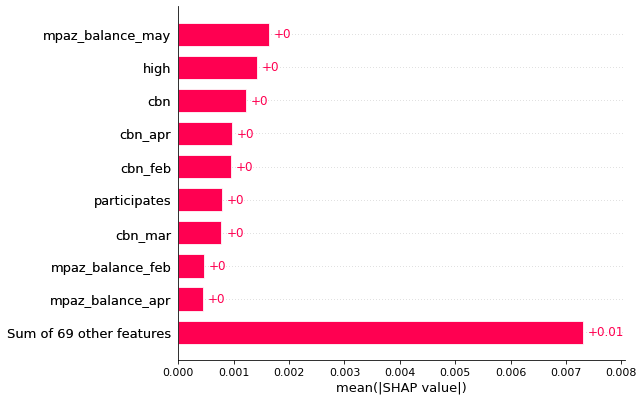

In [76]:
shap.plots.bar(shap_test[:,:,1])

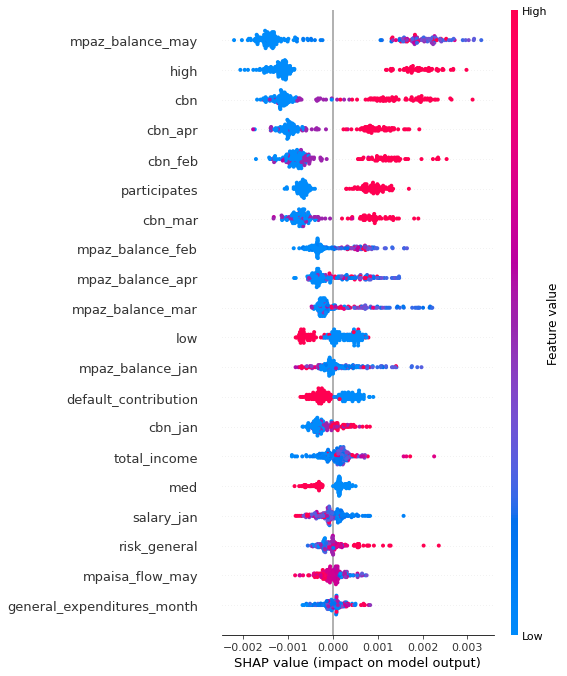

In [77]:
fig=plt.gcf()
shap.summary_plot(shap_test[:,:,1],show=False)
plt.savefig('shap_distribution_2.png')

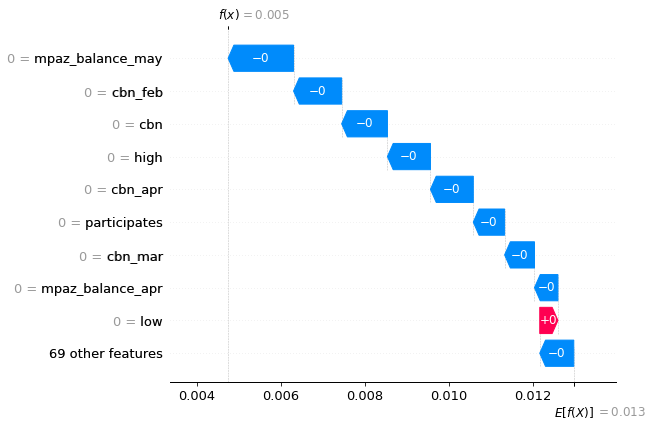

In [78]:
shap.plots.waterfall(shap_test[:,:,1][1])

#### predicting the desire to change savings

In [85]:
dataset =[begin_info,experiment,consult,end_info]
input_ = pd.concat([dataset[0],dataset[1]],axis=1)
for i in range(2,len(dataset)):
    input_ = pd.concat([input_,dataset[i]],axis=1)
input_ = input_.replace(-1,0)
input_['filter_desire'] = df1['e1_changed_desire']
input_ = input_.loc[pd.notna(input_['filter_desire'])]
input_ = input_.drop('e1_increased_desiretosave',axis=1)

y = input_.iloc[:,-1]
input_ = input_.iloc[:,:-2]
print(input_.shape,y.shape)

(781, 200) (781,)


In [86]:
input_std = preprocessing.StandardScaler().fit_transform(input_)

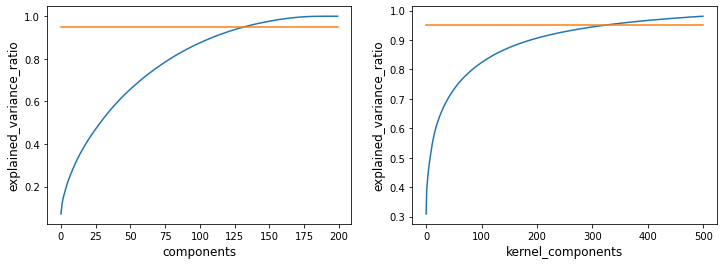

In [87]:
plot_all(input_std,500)

In [88]:
X = PCA(n_components=125).fit_transform(input_std)

##### Models

###### Logistic Regression


In [89]:
LR(input_std,y) # with the original dataset

(0.5787234042553191, LogisticRegression(random_state=42))

In [90]:
LR(X,y) # with dataset after transformation

(0.5914893617021276, LogisticRegression(random_state=42))

###### Decision Tree

In [91]:
DTo = DT(input_,y)

In [92]:
DTo

({'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'},
 0.6510638297872341,
 DecisionTreeClassifier(max_depth=5, random_state=42, splitter='random'))

In [93]:
DTt = DT(X,y)

In [94]:
DTt

({'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'},
 0.5361702127659574,
 DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42,
                        splitter='random'))

###### Random Forest

In [95]:
RFo= RF(input_,y)

In [96]:
RFo

({'criterion': 'gini', 'max_depth': 8, 'n_estimators': 94},
 0.7021276595744681,
 RandomForestClassifier(max_depth=8, n_estimators=94, random_state=42))

In [97]:
RFt= RF(X,y)

In [98]:
RFt

({'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 93},
 0.6127659574468085,
 RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=93,
                        random_state=42))

###### Neural Networks

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def create_model(activation='tanh'):
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    model = Sequential()
    model.add(Dense(25, input_shape=(200,), activation=activation))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', metrics=['accuracy'],optimizer='Adam')
    return model
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [3,5,7, 10,12, 15,17,20,23,25,27,30]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
model = KerasClassifier(model=create_model,
                       loss="binary_crossentropy",metrics='accuracy',epochs=5, batch_size=50, verbose=0)
#param_grid = dict(model__neurons=neurons)
param_grid = dict(model__activation=activation)
#param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy', n_jobs=5, cv=3)

In [100]:
X_train,X_test,y_train,y_test = train_test_split(input_std,y,test_size=0.3, random_state=42)# tuning neruons  with original dataset
grid_result = grid.fit(X_train,y_train) 
print(grid_result.best_params_,grid_result.best_score_)

{'model__activation': 'relu'} 0.6758241758241758


In [101]:
grid_result = grid.fit(X_train,y_train) # tuning activation 
print(grid_result.best_params_, grid_result.best_score_)

{'model__activation': 'relu'} 0.6758241758241758


In [102]:
grid_result = grid.fit(X_train,y_train) # tuning opimizer 
print(grid_result.best_params_, grid_result.best_score_)

{'model__activation': 'relu'} 0.6758241758241758


In [103]:
def create_binary_model(input_):   
    tf.keras.backend.clear_session()
    tf.random.set_seed(7)
    inputs = keras.Input(shape=(input_.shape[1],))
    x = tf.keras.layers.Dense(25, activation=tf.nn.relu)(inputs)
    outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'binary_crossentropy', metrics=['accuracy'],optimizer='Adam')
    return model

In [104]:
def NN_bi(X,y):    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    model = create_binary_model(X_train)
    model.fit(X_train,y_train,validation_split=0.1,batch_size= 50,epochs=5)
    accuracy = model.evaluate(X_test,y_test)[1]
    return accuracy,model

In [105]:
NNo = NN_bi(input_std,y)

Epoch 1/5
10/10 [==============================] - 0s 17ms/step - loss: 0.8504 - accuracy: 0.5275 - val_loss: 0.8524 - val_accuracy: 0.5636
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.5886 - val_loss: 0.7906 - val_accuracy: 0.6000
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 0.6301 - accuracy: 0.6599 - val_loss: 0.7484 - val_accuracy: 0.5818
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 0.5682 - accuracy: 0.7108 - val_loss: 0.7101 - val_accuracy: 0.5818
Epoch 5/5
8/8 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.6936


In [106]:
NNo

(0.693617045879364, <keras.engine.functional.Functional at 0x276437b3700>)

In [107]:
NNt = NN_bi(X,y)

Epoch 1/5
10/10 [==============================] - 0s 14ms/step - loss: 0.8874 - accuracy: 0.4888 - val_loss: 0.9961 - val_accuracy: 0.5091
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 0.7762 - accuracy: 0.5316 - val_loss: 0.9162 - val_accuracy: 0.5273
Epoch 3/5
10/10 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5825 - val_loss: 0.8509 - val_accuracy: 0.5455
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6660 - val_loss: 0.8016 - val_accuracy: 0.5636
Epoch 5/5
8/8 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.6043


In [108]:
NNt

(0.6042553186416626, <keras.engine.functional.Functional at 0x27646063fa0>)

##### Explanation 

In [109]:
X_train,X_test,y_train,y_test = train_test_split(input_,y,test_size=0.3, random_state=42)
model = RFo[2]
explainer = shap.Explainer(model)

In [110]:
shap_test = explainer(X_test)
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
            columns=shap_test.feature_names, 
            index=X_test.index)
shap_df

,education_level,missed_meals,withdraw_entire_salary,total_savings,uses_bank,male,bank_savings,cash_savings,loans_given,mpaisa_savings,...,e1_cash_amount,e1_violence_prime,money_mpaz_plan,financialproduct_mpaz,money_mpaz_spent,e1_switch_a,e1_switch_left_a,e1_switch_b,e1_switch_left_b,beta_el
730,-0.000872,0.000559,-0.000261,-0.003563,-0.000762,-0.000081,0.000868,0.000297,0.000552,-0.000376,...,0.000120,0.000051,0.044042,-0.010733,0.000398,0.002730,0.001044,-0.000128,0.000318,0.000769
720,-0.001490,0.000625,0.000483,0.000360,-0.000411,-0.000264,-0.008492,-0.000748,0.002999,-0.004345,...,0.000839,0.000043,-0.021484,0.002467,-0.000934,-0.005421,-0.000111,-0.000364,0.000044,0.002028
667,-0.001111,0.001245,0.001258,0.000707,0.000405,-0.000095,0.000674,0.000002,0.000206,0.004585,...,-0.000161,-0.000099,0.019904,0.001356,-0.002054,-0.006970,-0.001820,-0.000867,-0.000602,0.002783
788,0.000156,0.000094,-0.000168,-0.001219,0.000168,-0.000353,0.000258,-0.007595,0.003331,-0.003783,...,0.000327,0.000096,-0.021759,0.001364,-0.001465,-0.004820,-0.004631,-0.000483,0.001935,0.000262
599,-0.001503,-0.001587,0.001142,-0.007595,0.001474,-0.000110,0.000605,0.000090,0.000212,0.000247,...,0.000382,-0.000216,0.033155,-0.003472,-0.014538,-0.005788,-0.001402,-0.001173,-0.000859,-0.001334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.003025,-0.000278,0.000437,-0.004969,0.000331,-0.000498,0.001160,-0.000595,-0.000792,0.002139,...,-0.001131,-0.000285,-0.018745,-0.003314,-0.001484,0.005836,0.007693,0.002075,-0.000694,0.000325
259,-0.000041,-0.000033,0.000641,-0.003736,-0.002209,0.001043,0.000767,0.000171,-0.000114,-0.001024,...,0.000511,0.001196,-0.033740,0.001210,0.000014,0.001257,0.001794,0.001682,0.000983,-0.000816
711,0.000403,0.001451,0.000002,0.003915,-0.000603,-0.000088,-0.003941,0.000147,-0.000715,0.002222,...,0.000354,0.000213,0.039463,-0.007140,0.001517,0.001037,-0.001251,-0.001013,-0.000325,0.001042
440,0.000161,0.000109,0.000228,0.003147,-0.000549,0.005950,0.001272,-0.000079,-0.000456,-0.002835,...,0.002725,0.000050,-0.021152,0.000364,-0.000929,0.005707,0.005987,-0.000149,0.001944,0.000454


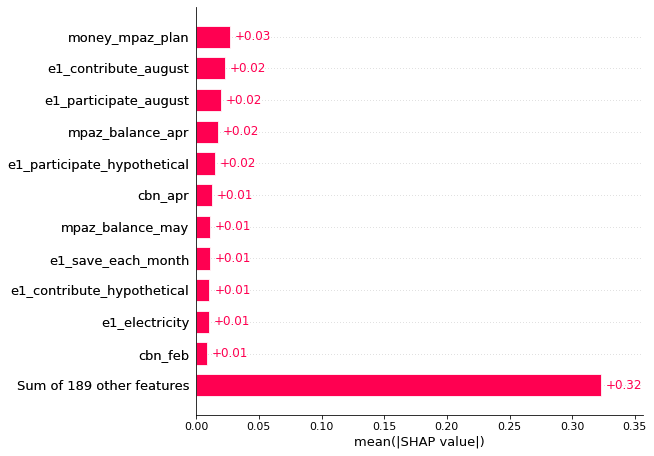

In [111]:
shap.plots.bar(shap_test[:,:,1],max_display=12)

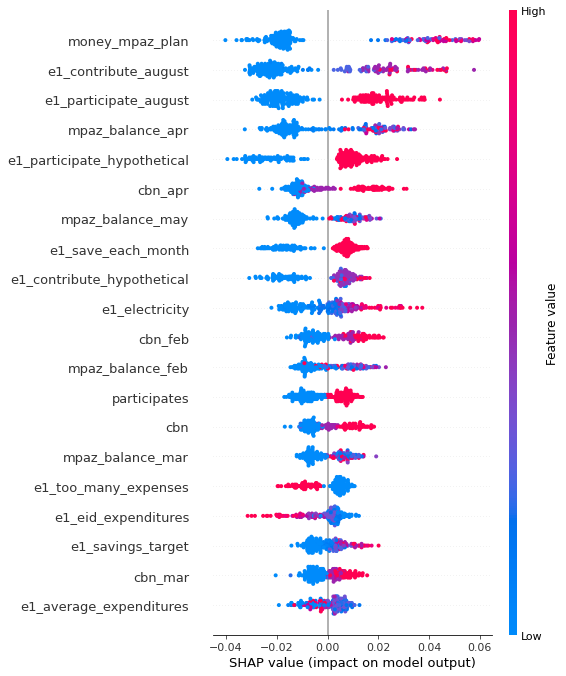

In [112]:
fig=plt.gcf()
shap.summary_plot(shap_test[:,:,1],show=False)
plt.savefig('shap_distribution_3.png')